# Baseline Neural Network Setup using k-fold Cross Validation

In [1]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow as tf
import keras_tuner
import math
import time

2024-02-02 22:59:33.769565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 22:59:33.769602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 22:59:33.770538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 22:59:33.775557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 22:59:34.398446: W tensorflow/compiler/tf2

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

In [21]:
# helper method to create a valid dataset
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

# method to create a TF dataset
def create_dataset(X_np_array, y_np_array, batch_size=32, sort=False):
    # sort the arrays
    if sort == True:
        # build an array containing the sequence lengths
        sequence_lengths = list(map(lambda x: len(x), X_np_array))
        # sort the array but only get the indices
        sorted_indices = np.argsort(sequence_lengths)
        # now sort the X and y train arrays according to the sorted indicds
        X_np_array = X_np_array[sorted_indices]
        y_np_array = y_np_array[sorted_indices]

    # create ragged tensor from in-homogeneous array
    # X_tensor = tf.ragged.constant(X_np_array, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
    X_tensor = bar = tf.RaggedTensor.from_row_lengths(
        values=tf.concat(X_np_array.tolist(), axis=0),
        row_lengths=[len(a) for a in X_np_array]
    )
    
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_np_array))

    # create a dataset of dense tensors
    ds = ds.map(reformat)

    # apply padded batching to the dataset
    ds = ds.padded_batch(batch_size)
    
    return ds

In [4]:
# method to plot two MAE arrays
def plot_loss(train_mae, val_mae, start_epoch=1):
    # get the number of epochs the training ran
    epochs = range(start_epoch, len(train_mae) + 1)
    # plot the graph
    plt.plot(epochs, train_mae, "bo", label="Training")
    plt.plot(epochs, val_mae, "b", label="Validation")
    plt.title("Training and Validation Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [5]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(drop1)
    dense = layers.Dense(128, activation='relu')(pool1)
    outputs = layers.Dense(1)(dense)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [6]:
def dan_zrimec_model():
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=392,
        kernel_size=3, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.4
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=192, 
            return_sequences=True, 
            recurrent_dropout=0.25
        ),
        merge_mode='mul'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=20,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.35
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=128,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.3
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')

    return model

In [7]:
def dan_zrimec_model2():
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=280,
        kernel_size=12, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.15
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=448, 
            return_sequences=True, 
            recurrent_dropout=0.3
        ),
        merge_mode='concat'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.1
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=128,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.45
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')

    return model

In [8]:
def run_model(model, train_ds, val_ds, epochs=10, start_epoch=1, oneshot=True, verbose=True):
    if verbose: 
        model.summary()
        verbose_fit = 'auto'
    else:
        verbose_fit = 0
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
        
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose_fit
    )
    
    if oneshot == True:
        plot_loss(
            history.history['mean_absolute_error'],
            history.history['val_mean_absolute_error'],
            start_epoch
        )

    if val_ds != None:
        return history.history['mean_absolute_error'], history.history['val_mean_absolute_error']

In [9]:
# simple timer from https://realpython.com/python-timer/

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
        else:
            self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
        else:
            elapsed_time = time.perf_counter() - self._start_time
            self._start_time = None
            print(f"    elapsed time: {elapsed_time:0.4f} seconds")

## Data Prep

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [10]:
# read the prepared data back
X = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [11]:
# build an inhomogenous numpy array from X
X = np.array(X, dtype=object)

In [12]:
# convert type of target values from string to float
y = np.array(y).astype(float)

Random sample from X and y.

In [13]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [14]:
y[0]

7.544

In [15]:
# count of input sequences
len(X)

8201

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [16]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

1.552 8.587 4.973957444214121 0.8835629329175175


In [17]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7055145713937325

### Splits

Split data in train and test sub sets

In [18]:
# split in train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1202)

In [19]:
# batch_size = 64 # too large for available GPU memory
# batch_size = 32 # too large for available GPU memory
batch_size = 16

In [22]:
# build the test dataset
test_ds = create_dataset(X_test, y_test, batch_size=batch_size, sort=False)

2024-02-02 23:00:42.368446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 23:00:42.368980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 23:00:42.369440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## k-Fold Cross Validation

In [23]:
num_splits = 5

### Augur Model

k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 605.4251 seconds
    creating validation dataset
    elapsed time: 70.6669 seconds
    fitting model


2024-01-28 01:52:22.197700: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-28 01:52:22.282379: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 01:52:22.421234: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 01:52:23.419130: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe04d3ddd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 01:52:23.419182: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-28 01:52:23.419201: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-28 01:52:23.419217: I external/local_xla/xla/service/service.cc:176]   Stream

    elapsed time: 396.8868 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 561.1615 seconds
    creating validation dataset
    elapsed time: 67.7402 seconds
    fitting model
    elapsed time: 392.5960 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 564.7888 seconds
    creating validation dataset
    elapsed time: 68.0808 seconds
    fitting model
    elapsed time: 388.1335 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0004 seconds
    creating training dataset
    elapsed time: 581.5906 seconds
    creating validation dataset
    elapsed time: 68.6518 seconds
    fitting model
    elapsed time: 382.9564 seconds
  processing fold 4
    splitting data
    elapsed time: 0.0004 seconds
    creating training dataset
    elapsed time: 594.0230 seconds
    creating validation dataset
    elapsed time: 67.5453 se

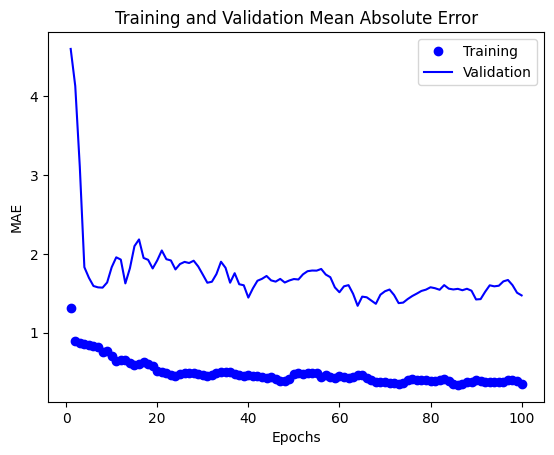

CPU times: user 1h 16min 54s, sys: 8min 49s, total: 1h 25min 43s
Wall time: 1h 26min 38s


In [22]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [23]:
# train final model

# model file name
model_name = 'model_baseline_augur.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_baseline_augur.keras for 40 epochs
  creating training dataset
    elapsed time: 892.8366 seconds
  building model
  training model
    elapsed time: 203.4803 seconds
  evaluating model
52/52 [==============================] - 11s 204ms/step - loss: 3.4444 - mean_absolute_error: 1.6631
  mean absolute evaluation error is [3.4443719387054443, 1.663144588470459]
  saving model


k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 582.8836 seconds
    creating validation dataset
    elapsed time: 70.6694 seconds
    fitting model
    elapsed time: 79687.4558 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0004 seconds
    creating training dataset
    elapsed time: 590.8862 seconds
    creating validation dataset
    elapsed time: 69.4183 seconds
    fitting model
    elapsed time: 80567.7080 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 568.0507 seconds
    creating validation dataset
    elapsed time: 68.2527 seconds
    fitting model
    elapsed time: 79962.0382 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset
    elapsed time: 564.4731 seconds
    creating validation dataset
    

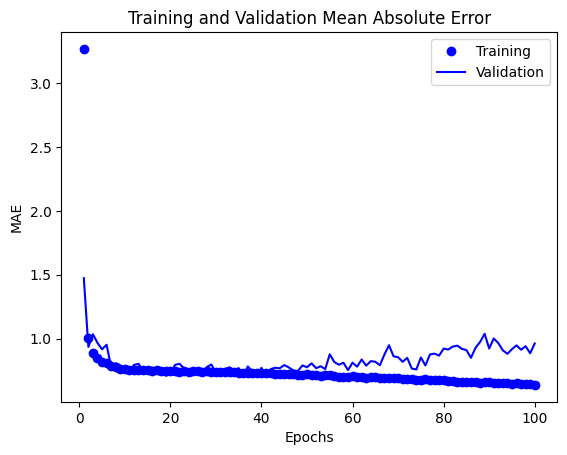

CPU times: user 8d 2h 42min 10s, sys: 19h 29min 57s, total: 8d 22h 12min 8s
Wall time: 4d 16h 36min 2s


In [24]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [25]:
# train final model

# model file name
model_name = 'model_baseline_danzrimec.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = dan_zrimec_model()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_baseline_danzrimec.keras for 40 epochs
  creating training dataset
    elapsed time: 893.0545 seconds
  building model
  training model
    elapsed time: 38156.3978 seconds
  evaluating model
52/52 [==============================] - 64s 1s/step - loss: 1.2973 - mean_absolute_error: 0.9593
  mean absolute evaluation error is [1.297318696975708, 0.9593136310577393]
  saving model


In [25]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model2(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0003 seconds
    creating training dataset


2024-02-02 23:05:14.820853: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 516.09MiB (rounded to 541164288)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-02 23:05:14.820993: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-02 23:05:14.821019: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 6, Chunks in use: 6. 1.5KiB allocated for chunks. 1.5KiB in use in bin. 49B client-requested in use in bin.
2024-02-02 23:05:14.821035: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-02-02 23:05:14.821050: I external/local

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_5248_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[16911380,4] and type int64 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [27]:
# train final model

# model file name
model_name = 'model_baseline_danzrimec2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = dan_zrimec_model2()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_baseline_danzrimec2.keras for 40 epochs
  creating training dataset
    elapsed time: 891.2710 seconds
  building model
  training model


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



ResourceExhaustedError: Graph execution error:

Detected at node BaselineModel/bidirectional_7/backward_lstm_7/transpose_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib64/python3.11/asyncio/events.py", line 80, in _run

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_505836/2699136404.py", line 28, in <module>

  File "/tmp/ipykernel_505836/4191678554.py", line 14, in run_model

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py", line 279, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py", line 409, in call

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/layers/rnn/base_rnn.py", line 556, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/layers/rnn/lstm.py", line 626, in call

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/backend.py", line 5198, in rnn

  File "/scratch/hawk/PTR-augur/notebooks/.venv/lib64/python3.11/site-packages/keras/src/backend.py", line 4809, in swap_batch_timestep

OOM when allocating tensor with shape[32,1527,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node BaselineModel/bidirectional_7/backward_lstm_7/transpose_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1005651]

# what are the steps?

- create ragged tensor from X_test
- create dataset from X_test and y_test

k-fold cross validation for the baseline neural network
- input is X_train, y_train
- using KFold this will be split in k folds
  - sort the trainin part
  - convert X to ragged tensor
  - create dataset
  - train
  - evaluate
- evaluate the cross fold performance
- rerun model with the whole dataset (test+val)
- save the model
```
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    # sort X_train_kf and y_train_kf
    # convert X_train_kf to ragged tensor
    # create dataset from X_train_kf and y_train_kf
    # do the training and evaluation
# evaluate the cross fold performance
```

train/val split for the full neural network -> separate jupyter notebook
- input X_train, y_train
- split the training test set again in train and val
- create ragged tensor from training X
- create dataset from training X and y
- train
- evaluate
- rerun the model with the whole dataset (test+val)
- save the model


what have both in common?
- data load and initial prep (up to the first split)
- model setup
- training setup
- visualisation
- evaluation -> this is just one command

helpful methods
- create_dataset(X, y, sort=False)
  input X and y, specify if the dataset should be sorted
  returns a TF dataset
- run_model(model, epochs, plot=True, plot_epoch_start=0)
- plot_loss()

- callbacks
    - earlystopping -> to limit training that doesn't progress, only for the tuner
    - backupandrestore -> for the full training as fault tolerance setup
    - modelcheckpoint -> to save the best model on the final train

In [ ]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [ ]:
# find the first unique PTR value that is also in y_train
train_idx = 0
for i in range(len(y)):
    count = 0
    for l in range(len(y)):
        if i != l and y[i] == y[l]:
            count += 1
            continue
    if count == 0:
        for m in range(len(y_train)):
            if y[i] == y_train[m]:
                train_idx = m
                break
train_idx

In [ ]:
# get a sample
X_train[train_idx]

In [ ]:
# get the matching target
search_y = y_train[train_idx]
search_y

In [ ]:
# find the target value in the raw dataset
full_idx = 0
for i in range(len(y)):
    if y[i] == search_y:
        print(i)
        full_idx = i

In [ ]:
# compare if the raw dataset entry matches the subset entry
if X[full_idx].all() == X_train[train_idx].all():
    print('OK')

### Sort Training Data

In [ ]:
# build an inhomogenous numpy array from the training set
X_train = np.array(X_train, dtype=object)

In [ ]:
# build an array containing the sequence lengths
sequence_lengths = list(map(lambda x: len(x), X_train))

In [ ]:
# sort the array but only get the indices
sorted_indices = np.argsort(sequence_lengths)

In [ ]:
sorted_indices

In [ ]:
# now sort the X and y train arrays according to the sorted indicds
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

In [ ]:
# check if the previously found values still correlate
for i in range(len(y_train)):
    if y_train[i] == search_y:
        print(X_train[i])

### Ragged Tensor Tests

In [ ]:
# this does not work since the sequences are of different length
# X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
%%time
X_train_tensor = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
X_val_tensor = tf.ragged.constant(X_val, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)

In [ ]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train))
X_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [ ]:
X_train_dataset.element_spec

In [ ]:
X_val_dataset.element_spec

In [ ]:
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

In [ ]:
X_train_dataset = X_train_dataset.map(reformat)
X_val_dataset = X_val_dataset.map(reformat)

In [ ]:
# shuffle the dataset (again) and create padded batches
batch_size = 64
X_train_dataset = X_train_dataset.padded_batch(batch_size)
X_val_dataset = X_val_dataset.shuffle(buffer_size=len(X_val), seed=1202).padded_batch(batch_size)

In [ ]:
# optinally repeat the dataset multiple times -> WHY?
# rep = 3
# X_train_dataset = X_train_dataset.repeat(rep)
# X_val_dataset = X_val_dataset.repeat(rep)

In [ ]:
datalen = []
ds_iterator = iter(X_train_dataset)
for data, label in ds_iterator:
    datalen.append(len(data[1]))

In [ ]:
datalen[:5]

In [ ]:
# testing if keras can use the dataset
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(None,4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_dataset, epochs=1)